In [82]:
# local version, copied from Eagle
# JLCY 2021-02-12

# based on: 
# /a2e-mmc/assessment/blob/master/examples/UsingTSLISToutput.ipynb

# developed on Mac WE42120

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

data_dir = '/Users/leec813/Documents/mmc/sgp/data/'
obs_dir = data_dir+'obs/'
era_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/era5/'
gfs_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/gfs/'

# time step of wrf runs:
erad01_wrf_dt = 6
erad02_wrf_dt = 2
gfs_wrf_dt = 9

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(data_dir+'data-dir-name.csv', index_col=0)

# obs
wp_winds_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
wp_vstat_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

wp_winds = xr.open_mfdataset(wp_winds_ncs)
wp_vstat = xr.open_mfdataset(wp_vstat_ncs)

# according to Rob Newsom, lidar data taken < 100 m need to be thrown out
toss_wp_data_below_height = 100

# vertical profile plot top height threshold
profile_hgt_thres = 2000

# plotting variables
wp_winds_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
wp_stats_dict = {'w': ['w', r'w (m s$^{-1}$)']}

In [78]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):
    
    # select data at few heights above threshold height
#     wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height))
#                            .values[0:10])

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height))
                           .values)
    
    return [x for x in wp_height_list if str(x) != 'nan']

# def plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units): 

#     lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
#     lw = 1

#     # reverse height list, useful for plotting
#     wp_height_list = get_wp_height_list(wp_ds)[:len(lc_list)][::-1]

#     for hgt, lc in enumerate(lc_list): 

#         # slice of data at each height
#         wrf_slice = wrf_ds.sel(height=wp_height_list[hgt])
#         wp_slice = wp_ds.sel(height=wp_height_list[hgt])

#         plt.plot(wrf_slice['datetime'], wrf_slice[wrf_var], 
#                  label=str(np.round(wrf_slice['height'].values).astype(int))+' m', 
#                  c=lc, linewidth=lw)
#         plt.plot(wp_slice['time'], wp_slice[wp_var], c=lc, linewidth=lw, linestyle='--')

#     plt.xticks(rotation='vertical')
#     # 24 hours of data in plot
#     plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
#     plt.ylabel(var_units)

#     plt.title(wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)
#     plt.legend(title=wrf_run)

#     plt.show()
    
def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time (Z)')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    # height_top_i = 30
    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[0::20])): 

        wrf_time = wrf_synctime['time'][time_i].values.astype('datetime64[s]').tolist()
        
        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])
        
#         ax[1].plot(wrf_synctime[wrf_var][time_i, :height_top_i, 0], wrf_synctime['height'][:height_top_i], 
#                    c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
#         ax[1].plot(wp_synctime[wp_var][time_i, :height_top_i], wp_synctime['height'][:height_top_i], 
#                    linestyle='--', c=profile_lc[ind])

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

    plt.show()

def read_wp_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    era_wrf_dir = era_wrf_all_dir+date_col['era']+'/'

    erad01_file_name = 'c1.d01'
    erad01_file_path = era_wrf_dir+erad01_file_name
    erad01_tower = Tower(erad01_file_path)

    erad02_file_name = 'c1.d02'
    erad02_file_path = era_wrf_dir+erad02_file_name
    erad02_tower = Tower(erad02_file_path)

    gfs_wrf_dir = gfs_wrf_all_dir+date_col['gfs']+'/'
    
    gfs_file_name = 'SGP.d01'
    gfs_file_path = '{}{}'.format(gfs_wrf_dir, gfs_file_name)
    gfs_tower = Tower(gfs_file_path)

    # simulation start time:
    # era & gfs runs have the same start times
    wrf_start = date_col['wrf_start']

    tower_list = [erad01_tower, erad02_tower, gfs_tower]
    dt_list = [erad01_wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    erad01_ds = read_tower_to_ds(erad01_tower, wrf_start, erad01_wrf_dt, wrf_height_list)
    erad02_ds = read_tower_to_ds(erad02_tower, wrf_start, erad02_wrf_dt, wrf_height_list)
    gfs_ds = read_tower_to_ds(gfs_tower, wrf_start, gfs_wrf_dt, wrf_height_list)
            
    return obs_ds, erad01_ds, erad02_ds, gfs_ds

def plot_wp_wrf_ts_taydiag(obs, eval_date, lev_i=0): 

    obs_ds, erad01_ds, erad02_ds, gfs_ds = read_wp_wrf_1day(obs, eval_date)
    
    wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}

    # get start & end time to trim time series
    time_start = np.max([erad01_ds['datetime'].min().values, erad01_ds['datetime'].min().values, 
                       gfs_ds['datetime'].min().values, obs_ds['time'].min().values])
    time_end = np.min([erad01_ds['datetime'].max().values, erad01_ds['datetime'].max().values, 
                       gfs_ds['datetime'].max().values, obs_ds['time'].max().values])

    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [erad01_ds, erad02_ds, gfs_ds]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if len(time_freq) > len(model_time_freq): 

            time_freq = model_time_freq
            
    obs_height_list = get_wp_height_list(obs_ds)

    obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
    erad01_slice = erad01_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    erad02_slice = erad02_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    gfs_slice = gfs_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

    for wrf_var, var in wp_winds_dict.items():
        
        print('######################################################################')
        
        for wrf_run, wrf_ds in wrf_dict.items(): 

            # plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1])
            plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1], time_freq)

        models = {}
        models['erad01'] = erad01_slice[wrf_var]
        models['erad02'] = erad02_slice[wrf_var]
        models['gfs'] = gfs_slice[wrf_var]

        fig = plt.figure(figsize=(8, 8))
        td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                           srange=(0, 1.6), extend=False,
                           corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                           #minorcorrticks=np.arange(0.05,0.9,0.1),
                           #stdevticks=np.arange(0.2,2,0.2),
                           labelsize='x-large')

        for name, series in models.items():
            corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
            R2 = corr_xy**2
            stdev = series.std().values
            # print(name, stdev, R2)
            td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

        td.add_grid()

        contours = td.add_contours(levels=15, colors='0.5')
        plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

        fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
                   numpoints=1, prop=dict(size='medium'), loc='upper right')

        plt.title(var[0]+' @ '+str(np.round(obs_slice['height'].values).astype(int))+' m')

        plt.show()

In [80]:
obs_ds, erad01_ds, erad02_ds, gfs_ds = read_wp_wrf_1day(wp_vstat, '2018-08-05')

In [81]:
obs_ds

<xarray.Dataset>
Dimensions:               (bound: 2, height: 130, time: 144)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:...
  * height                (height) float32 105.0 135.0 ... 3.945e+03 3.975e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    snr                   (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_25                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    snr_75                (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_25                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_75                  (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    noise                 (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_variance            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_skewness            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    w_kurtosis            (time, height) float32 dask.array<chunksize=(144, 130), meta=np.ndarray>
    dl_cbh                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_25             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_75             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh_zmax           (time) float64 1.198e+04 1.198e+04 ... 1.198e+04
    dl_cloud_frequency    (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw                   (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_25                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_75                (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    cbw_up_fraction       (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    nshots                (time) float64 3e+04 3e+04 3e+04 ... 3e+04 3e+04 3e+04
    ngate_samples         (time) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0
    averaging_time        (time) float64 1.8e+03 1.8e+03 ... 1.8e+03 1.8e+03
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    sample_frequency      (time) float64 5e+07 5e+07 5e+07 ... 5e+07 5e+07 5e+07
    wavelength            (time) float64 1.548e-06 1.548e-06 ... 1.548e-06
    ceil_cbh              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_25           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_75           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_cbh_zmax         (time) float64 7.7e+03 7.7e+03 ... 7.7e+03 7.7e+03
    ceil_cloud_frequency  (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ceil_lat              (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    ceil_lon              (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    ceil_alt              (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    ecor_temp             (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_h2o              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_tke              (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_ustar            (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_w_var            (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    ecor_w_skew           (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>


In [45]:
erad01_ds

<xarray.Dataset>
Dimensions:   (datetime: 20200, height: 167, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-04T12:00:06 ... 2018-08-05T21...
  * height    (height) float64 10.0 20.0 30.0 ... 3.915e+03 3.945e+03 3.975e+03
  * station   (station) <U2 'c1'
Data variables:
    u         (datetime, height, station) float64 -1.568 -1.573 ... 1.226 0.9438
    w         (datetime, height, station) float64 -0.004267 ... -0.02048
    pr        (datetime, height, station) float64 9.77e+04 ... 6.269e+04
    v         (datetime, height, station) float64 4.392 4.532 ... 0.9788 1.038
    theta     (datetime, height, station) float64 297.8 297.8 ... 319.0 319.2
    qv        (datetime, height, station) float64 0.009951 0.009911 ... 0.002981
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (datetime, station) float64 295.9 295.9 295.8 ... 309.3 309.3
    q2        (datetime, station) float64 0.01 0.01 0.01001 ... 0.01262 0.01262
    u10       (datetime, station) float64 -1.574 -1.571 ... -0.3635 -0.3644
    v10       (datetime, station) float64 4.418 4.396 4.358 ... 6.657 6.657
    psfc      (datetime, station) float64 9.778e+04 9.778e+04 ... 9.775e+04
    lwd       (datetime, station) float64 367.7 367.7 367.7 ... 427.7 427.7
    swd       (datetime, station) float64 24.27 24.27 24.27 ... 548.9 548.9
    hfx       (datetime, station) float64 -27.48 -39.86 -39.42 ... 193.1 193.1
    lfx       (datetime, station) float64 30.65 28.01 28.13 ... 208.3 208.3
    tsk       (datetime, station) float64 295.4 295.0 294.9 ... 312.4 312.4
    slttop    (datetime, station) float64 297.5 297.5 297.5 ... 307.3 307.3
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (datetime, height, station) float64 4.663 4.798 ... 1.569 1.403
    wd        (datetime, height, station) float64 160.4 160.9 ... 231.4 222.3

######################################################################


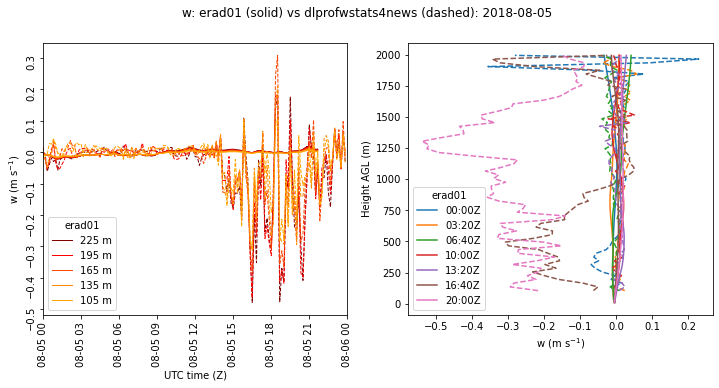

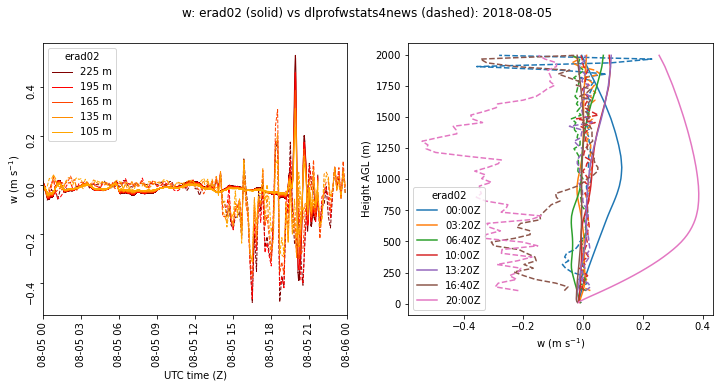

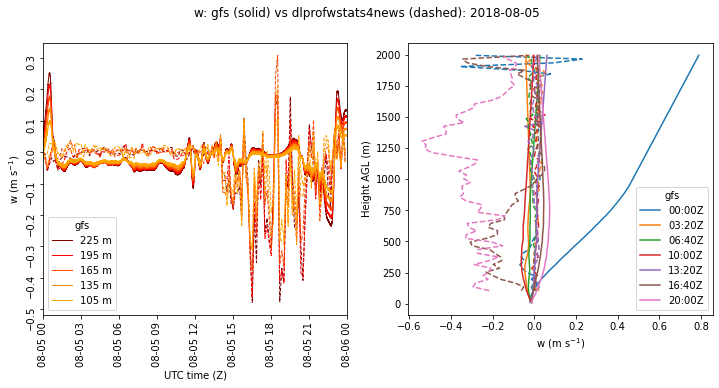

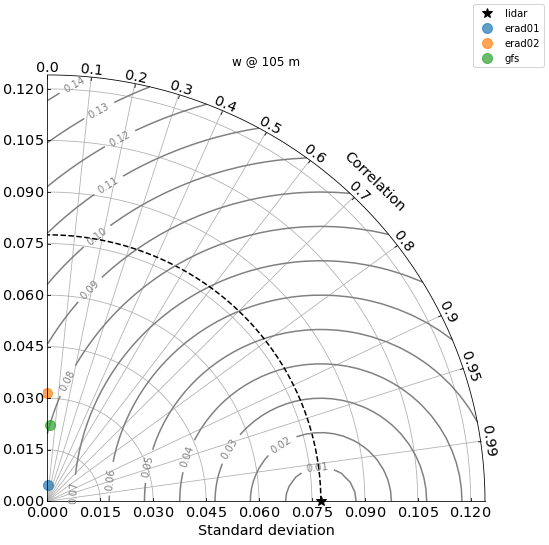

In [85]:
lev_i = 0
eval_date = '2018-08-05'

wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}

# get start & end time to trim time series
time_start = np.max([erad01_ds['datetime'].min().values, erad01_ds['datetime'].min().values, 
                   gfs_ds['datetime'].min().values, obs_ds['time'].min().values])
time_end = np.min([erad01_ds['datetime'].max().values, erad01_ds['datetime'].max().values, 
                   gfs_ds['datetime'].max().values, obs_ds['time'].max().values])

# start w/ obs
time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

# refer to the most infrequent data series
# need matching time dimension to calculate correlation, etc. 
for model in [erad01_ds, erad02_ds, gfs_ds]: 

    model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

    if len(time_freq) > len(model_time_freq): 

        time_freq = model_time_freq

obs_height_list = get_wp_height_list(obs_ds)

obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
erad01_slice = erad01_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
erad02_slice = erad02_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
gfs_slice = gfs_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

for wrf_var, var in wp_stats_dict.items():

    print('######################################################################')

    for wrf_run, wrf_ds in wrf_dict.items(): 

        plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1], time_freq)

    models = {}
    models['erad01'] = erad01_slice[wrf_var]
    models['erad02'] = erad02_slice[wrf_var]
    models['gfs'] = gfs_slice[wrf_var]

    fig = plt.figure(figsize=(8, 8))
    td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                       srange=(0, 1.6), extend=False,
                       corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                       #minorcorrticks=np.arange(0.05,0.9,0.1),
                       #stdevticks=np.arange(0.2,2,0.2),
                       labelsize='x-large')

    for name, series in models.items():
        corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
        R2 = corr_xy**2
        stdev = series.std().values
        # print(name, stdev, R2)
        td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

    td.add_grid()

    contours = td.add_contours(levels=15, colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
               numpoints=1, prop=dict(size='medium'), loc='upper right')

    plt.title(var[0]+' @ '+str(np.round(obs_slice['height'].values).astype(int))+' m')

    plt.show()

######################################################################


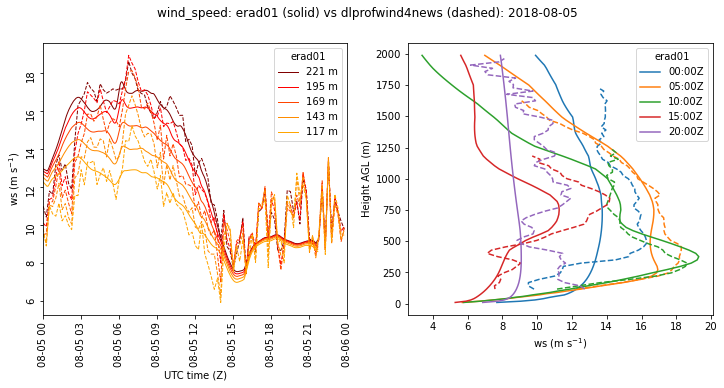

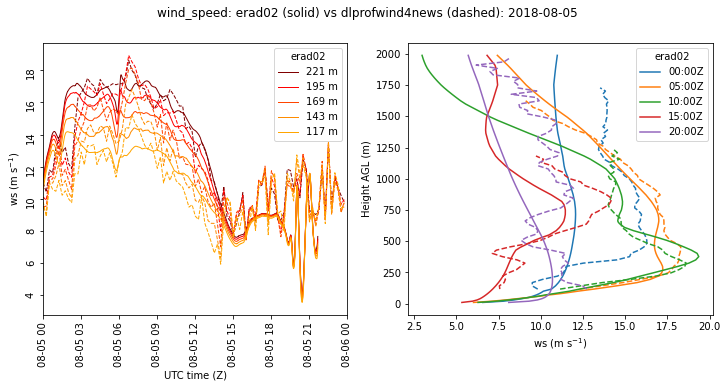

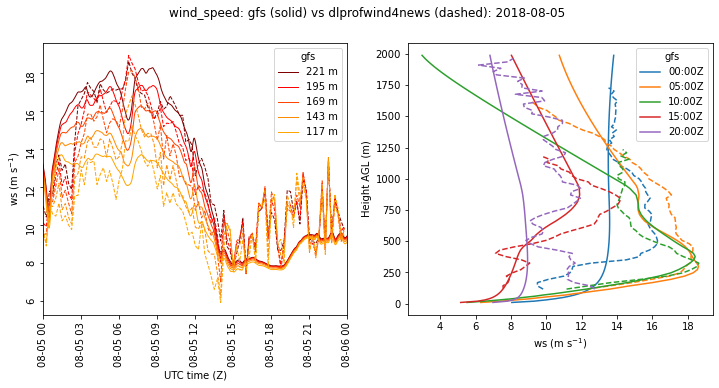

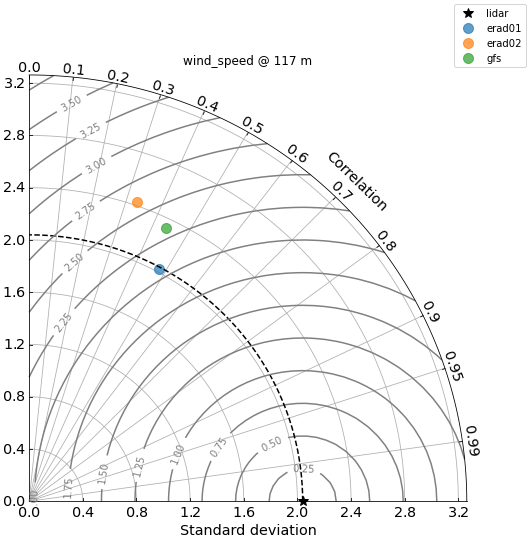

######################################################################


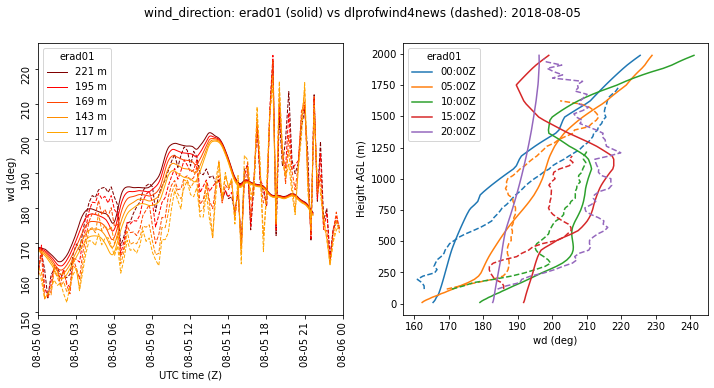

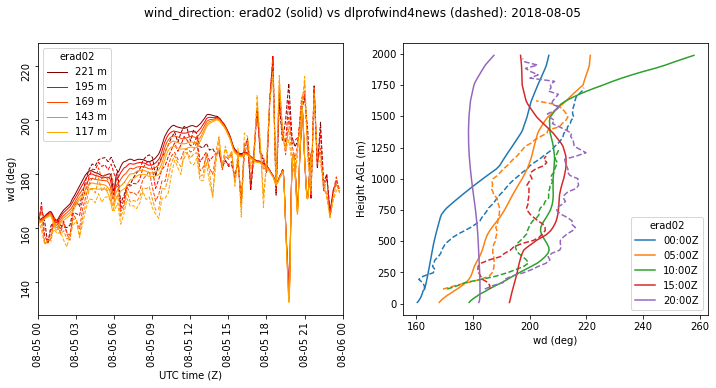

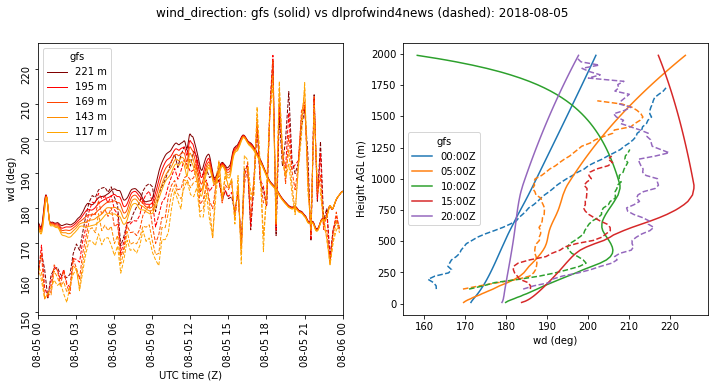

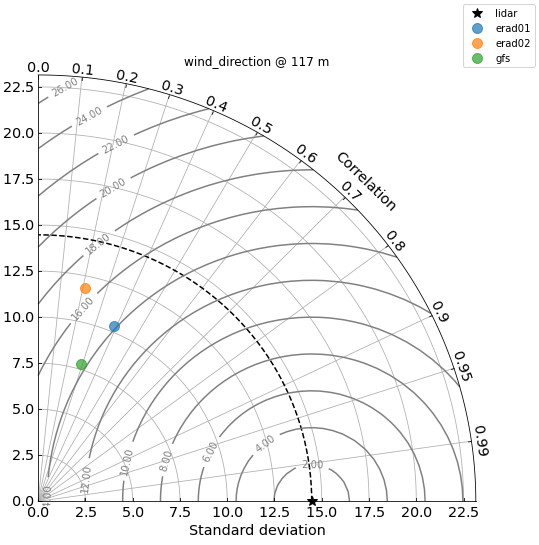

In [79]:
plot_wp_wrf_ts_taydiag(wp_winds, '2018-08-05')

######################################################################


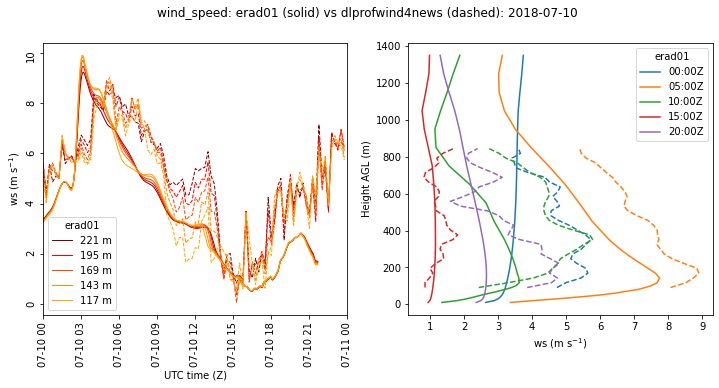

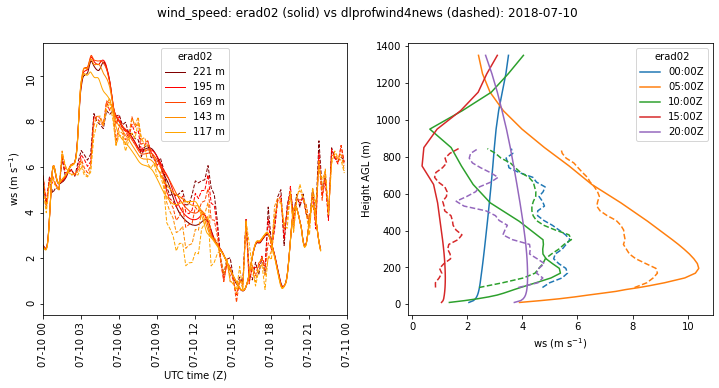

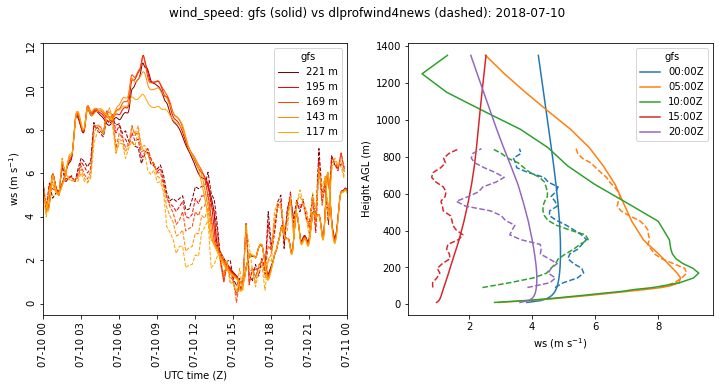

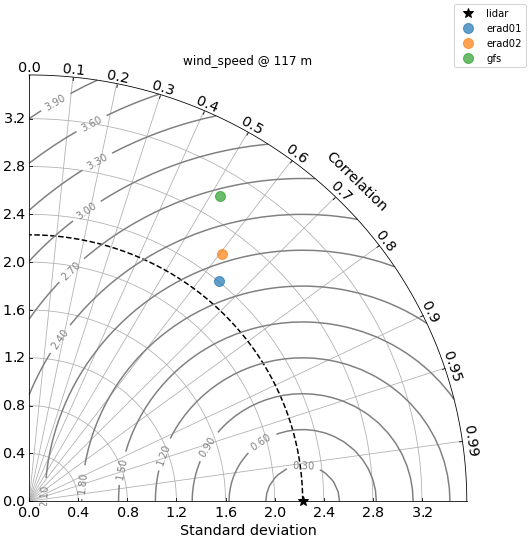

######################################################################


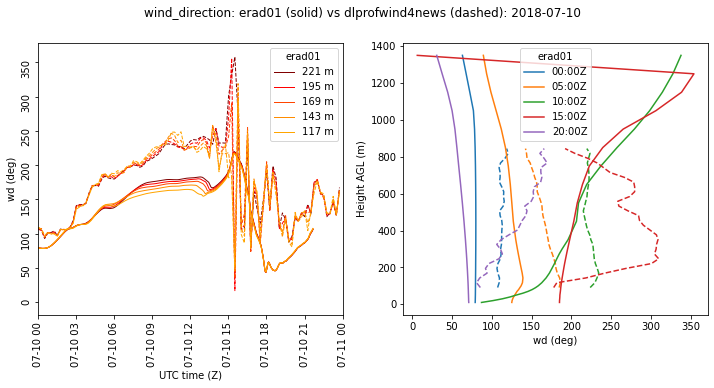

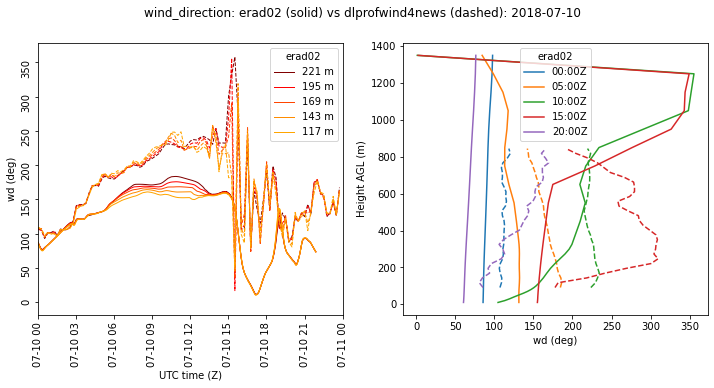

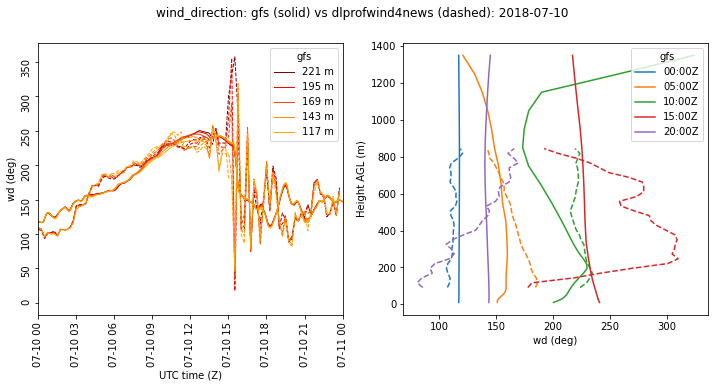

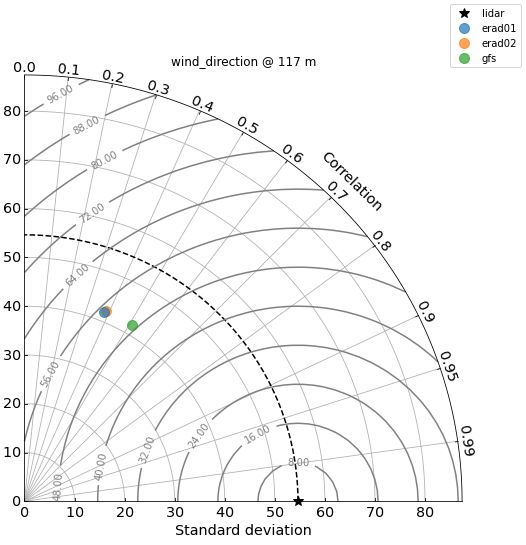

In [4]:
plot_wp_wrf_ts_taydiag(wp_winds, '2018-07-10')

# obs

# wrf

# compare

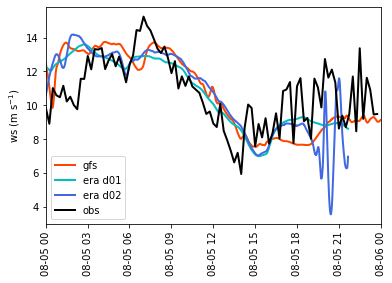

In [53]:
lw = 2
plt.plot(gfs_ds['datetime'], gfs_ds['ws'][:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(erad01_ds['datetime'], erad01_ds['ws'][:, 1], label='era d01', c='c', linewidth=lw)
plt.plot(erad02_ds['datetime'], erad02_ds['ws'][:, 1], label='era d02', c='royalblue', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_speed'][:, 1], label='obs', c='k', linewidth=lw)
plt.xticks(rotation='vertical')
plt.xlim(parser.parse('2018-08-05'), parser.parse('2018-08-06'))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()